# Segmentation

In this notebook we will attempt to segment the lumbar disc and save the segmentation as a NRRD file.

The approach will consist of:

1. Loading the data
2. Placing segmentation seeds
3. Growing the segmentation from seeds using the Slicer segmentation editor
4. Saving the result

To try several different segmentation approaches one might want to install a ***SegmentEditorExtraEffects*** extension via the Extension Manager.
In this notebook only default effects are used.

---

Let's setup the notebook environment. Do the imports and set a FourUp UI layout.

In [1]:
import os
try:
    import numpy as np
    import JupyterNotebooksLib as slicernb
except ImportError as e:
    print(f'Imports failed with the following message: {e}.\nSlicer environment was not setup correctly.')

In [2]:
sys.path.append(os.getcwd())
import playground_utils

Like in previous notebooks we've created a couple of local helper functions that will probably migrate to `playground_utils` later.

In [3]:
def create_seed_geometry(seedPositions: list, seedSize: int) -> vtk.vtkPolyData:
    """
    Create spheres at given positions.

    :param      seedPositions:  A list of lists of seed coordinates [r, a, s]
    :type       seedPositions:  list
    :param      seedSize:       The sphere diameter
    :type       seedSize:       int

    :returns:   A vtk filter that has vtkPolyData as output
    :rtype:     vtkPolyData
    """
    seedGeometry = vtk.vtkAppendPolyData()
    for position in seedPositions:
        seed = vtk.vtkSphereSource()
        seed.SetCenter(position)
        seed.SetRadius(seedSize)
        seed.Update()
        seedGeometry.AddInputData(seed.GetOutput())
        seedGeometry.Update()
    return seedGeometry

In [4]:
def rotate_x(geometry: vtk.vtkPolyData,
             angle: int,
             centerPoint: list) -> vtk.vtkTransformPolyDataFilter:
    """
    Rotate vtkPolyData axainst X axis.

    Generates a transform filter
    and applies rotation to a vtkPolyData input.

    :param      geometry:     The geometry
    :type       geometry:     vtkPolyData
    :param      angle:        The angle (degrees)
    :type       angle:        int
    :param      centerPoint:  Coordinates of the PolyData center
    :type       centerPoint:  list

    :returns:   A vtk filter that has the rotated data as output.
    :rtype:     vtkTransformPolyDataFilter
    """
    transform = vtk.vtkTransform()
    transform.Translate(centerPoint[0], centerPoint[1], centerPoint[2])
    transform.RotateX(angle)
    transform.Translate(-centerPoint[0], -centerPoint[1], -centerPoint[2])
    transformFilter = vtk.vtkTransformPolyDataFilter()
    transformFilter.SetTransform(transform)
    transformFilter.SetInputConnection(geometry.GetOutputPort())
    transformFilter.Update()
    return transformFilter

In [5]:
lm = slicer.app.layoutManager()
lm.setLayout(slicer.vtkMRMLLayoutNode.SlicerLayoutFourUpView)

### Load the data from local storage

In [6]:
DISC_IMAGE = 'l5_s1_disc'
file_path = os.path.join(os.getcwd(), 'img', f'{DISC_IMAGE}.nrrd')
volumeNode = slicer.util.loadVolume(file_path)
volumeNode.SetName(DISC_IMAGE)
playground_utils.log_image_info(volumeNode)

Volume name: l5_s1_disc
Origin: (-29.736299514770504, -109.7360000610351, -71.73629760742185)
Spacing: (0.6800000071525573, 0.6800000071525573, 0.6800000071525573)
Dimensions: (88, 88, 88)



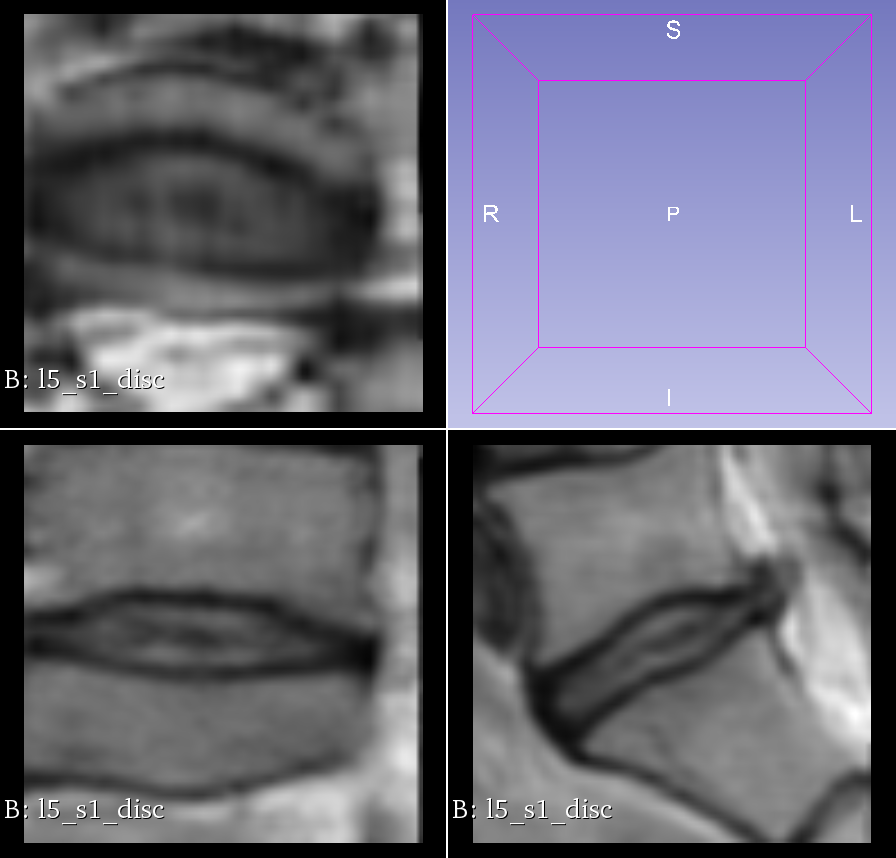

In [7]:
playground_utils.fit_slice_view()
slicernb.ViewDisplay('FourUp', False)

### Place segmentation seeds

The segmentation seeds are small samples of the segmentation. Before we can actually place segmentation seeds we need to prepare a segmentation node.

In [8]:
segmentationNode = slicer.vtkMRMLSegmentationNode()
slicer.mrmlScene.AddNode(segmentationNode)
segmentationNode.CreateDefaultDisplayNodes() # only needed for display
segmentationNode.SetReferenceImageGeometryParameterFromVolumeNode(volumeNode)

Now let's define and place the seeds for the lumbar disc and the surrounding tissue (background).

The idea is to create a grid of samples with the center in the point that we used to certer our ROI in the Data sampling notebook and roughly rotate it so that the grid elements will roughly overlap the required anatomical structures.

In [9]:
seed = [5, -79, -42]
sourceSeed = np.array([seed])
offset = 20

discSeedPositions = sourceSeed
for _o in [offset, -offset]:
    shiftedSeed = [[sourceSeed[0][0] + _o, sourceSeed[0][1], sourceSeed[0][2]]]
    discSeedPositions = np.concatenate((discSeedPositions, shiftedSeed))

for point in sourceSeed:
    for _o in [offset, -offset]:
        shiftedSeed = [[point[0], point[1] + _o, point[2]]]
        discSeedPositions = np.concatenate((discSeedPositions, shiftedSeed))

discSeedGeometry = create_seed_geometry(discSeedPositions, 2)

In [10]:
offsetS = 15

backgroundSeedPositions = None
for point in discSeedPositions:
    for _o in [offsetS, -offsetS]:
        shiftedSeed = [[point[0], point[1], point[2] + _o]]
        if backgroundSeedPositions is None:
            backgroundSeedPositions = np.array(shiftedSeed)
        else:
            backgroundSeedPositions = np.concatenate((backgroundSeedPositions, shiftedSeed))

backgroundSeedGeometry = create_seed_geometry(backgroundSeedPositions, 2)

So now that we've created the spheres for the sample grid we can apply the rotation and make segmentation seeds out of it.

In [11]:
discSeedGeometry = rotate_x(discSeedGeometry, -30, seed)
backgroundSeedGeometry = rotate_x(backgroundSeedGeometry, -30, seed)

In [12]:
discSegment = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(
                                    discSeedGeometry.GetOutput(), "D_L5S1", [1.0,0.0,0.0])
backgroundSegment = segmentationNode.AddSegmentFromClosedSurfaceRepresentation(
                                    backgroundSeedGeometry.GetOutput(), "V_L5S1", [0.0,1.0,0.0])

Let's adjust the view for the segmentation to be visible.

Aim the slice view at the center of our seed grid.

In [13]:
playground_utils.show_slice_in_slice_view(volumeNode, seed[2], 'Red')
playground_utils.show_slice_in_slice_view(volumeNode, seed[1], 'Green')
playground_utils.show_slice_in_slice_view(volumeNode, seed[0], 'Yellow')

And move the camera in 3d view

In [14]:
view = lm.threeDWidget(0).threeDView()
threeDViewNode = view.mrmlViewNode()
cameraNode = slicer.modules.cameras.logic().GetViewActiveCameraNode(threeDViewNode)
cameraNode.SetPosition([-130, -102, 64])
cameraNode.SetFocalPoint(seed)
cameraNode.SetViewUp([0.4, 0.6, 0.6])

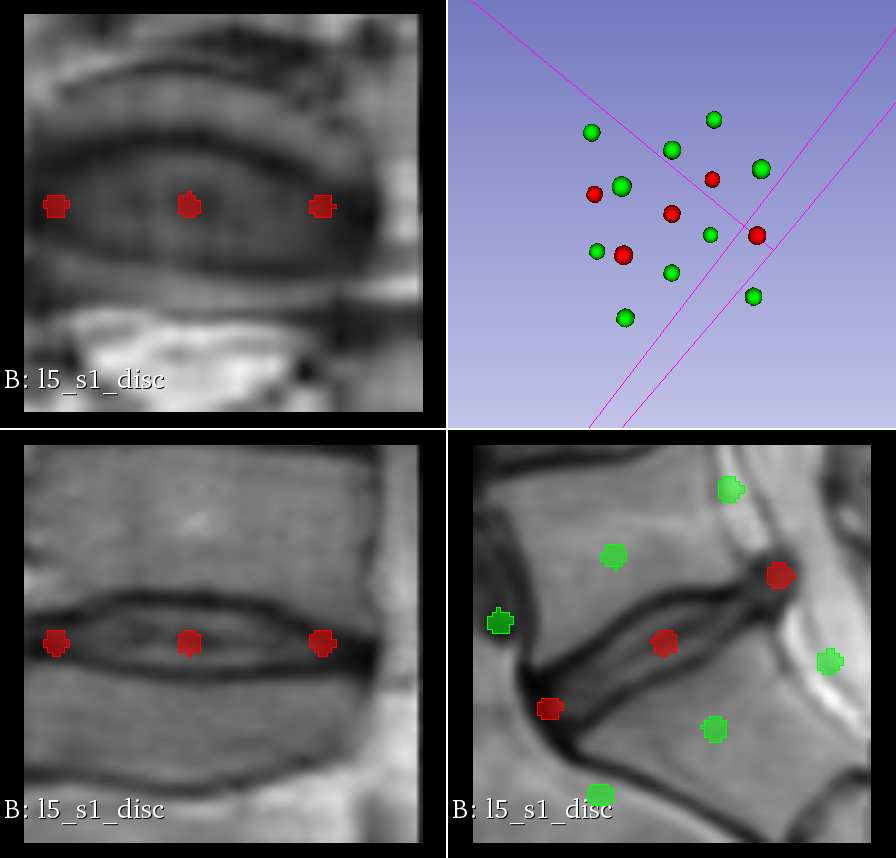

In [15]:
slicernb.ViewDisplay('FourUp', False)

---

#### Grow from seeds

This section was taked from the [SlicerNotebooks/04_Segmentation.ipynb](SlicerNotebooks/04_Segmentation.ipynb).

Apart from launching the `"Grow from seeds"` effect it shows a more general example of interaction with module widgets.

In [16]:
# Run filter
################################################

# Create segment editor to get access to effects
segmentEditorWidget = slicer.qMRMLSegmentEditorWidget()
segmentEditorWidget.show()

segmentEditorWidget.setMRMLScene(slicer.mrmlScene)
segmentEditorNode = slicer.vtkMRMLSegmentEditorNode()
slicer.mrmlScene.AddNode(segmentEditorNode)
segmentEditorWidget.setMRMLSegmentEditorNode(segmentEditorNode)
segmentEditorWidget.setSegmentationNode(segmentationNode)
segmentEditorWidget.setMasterVolumeNode(volumeNode)

# Run segmentation
segmentEditorWidget.setActiveEffectByName("Grow from seeds")
effect = segmentEditorWidget.activeEffect()
# You can change parameters by calling: effect.setParameter("MyParameterName", someValue)
# Most effect don't have onPreview, you can just call onApply
effect.self().onPreview()
effect.self().onApply()

self.extentGrowthRatio = 0.1
masterImageExtent = (0, 87, 0, 87, 0, 87)
labelsEffectiveExtent = (19, 83, 6, 84, 8, 80)
labelsExpandedExtent = [13, 87, 0, 87, 1, 87]
Grow-cut operation on volume of 75x88x87 voxels was completed in 0.4 seconds.


#### Grow from seeds result

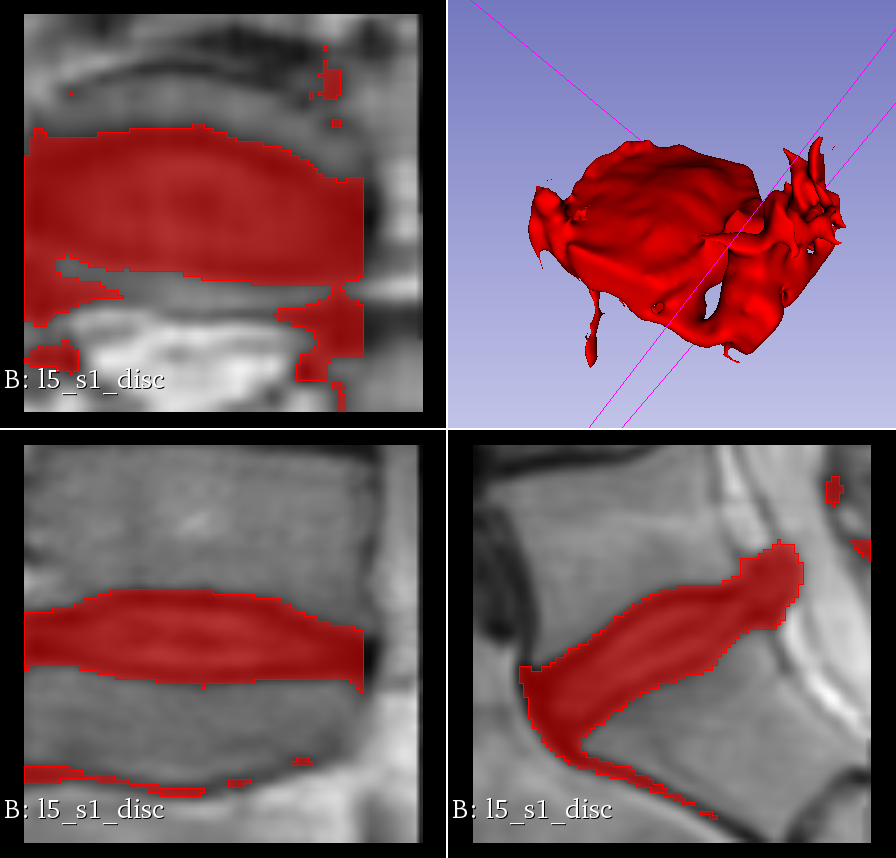

In [17]:
slicernb.ViewDisplay('FourUp', False)

Grow from seeds gives us a good base. now we can try to clean this segmentation up.

The approach is to:

- shrink (erode) the segmentation a couple of voxels so that the tiny parts either disappear or detach to become islands.
- identify segment islands and keep only 1 largest segment
- smooth the segment
- and inflate (dilate) the segment back a bit

---

#### Let's clean up.

Erode 2mm

In [18]:
segmentEditorWidget.setActiveEffectByName("Margin")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("MarginSizeMm", "-2")
effect.self().onApply()

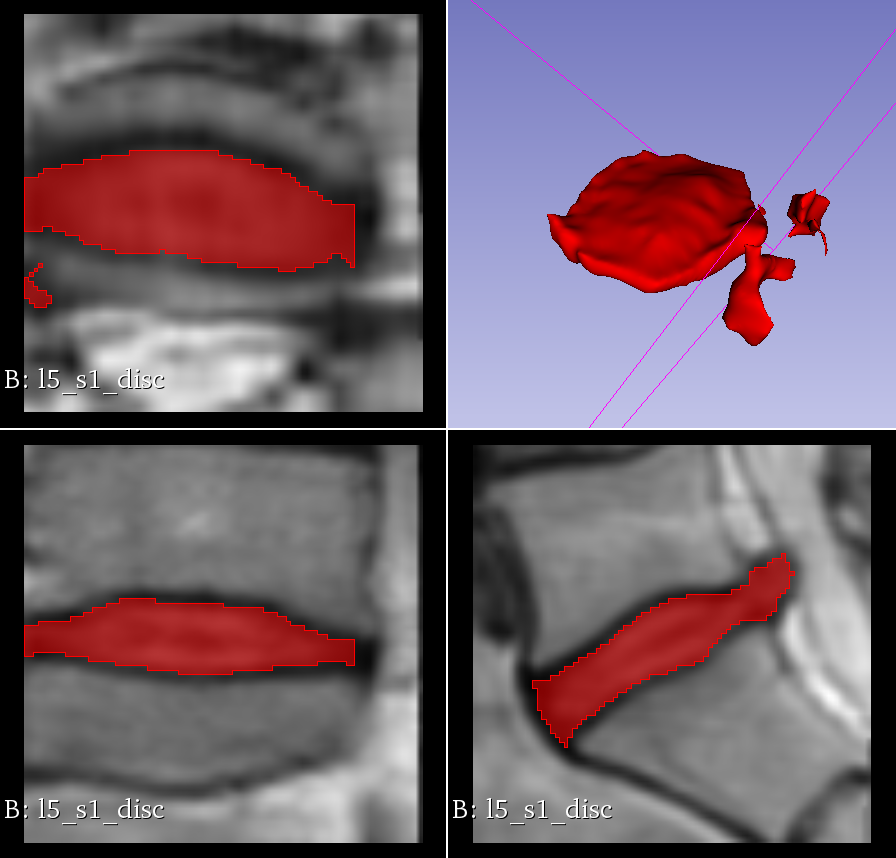

In [19]:
slicernb.ViewDisplay('FourUp', False)

Identify islands and keep only the largest

In [20]:
segmentEditorWidget.setActiveEffectByName("Islands")
effect = segmentEditorWidget.activeEffect()
effect.self().onApply()

3 islands created (28 ignored)


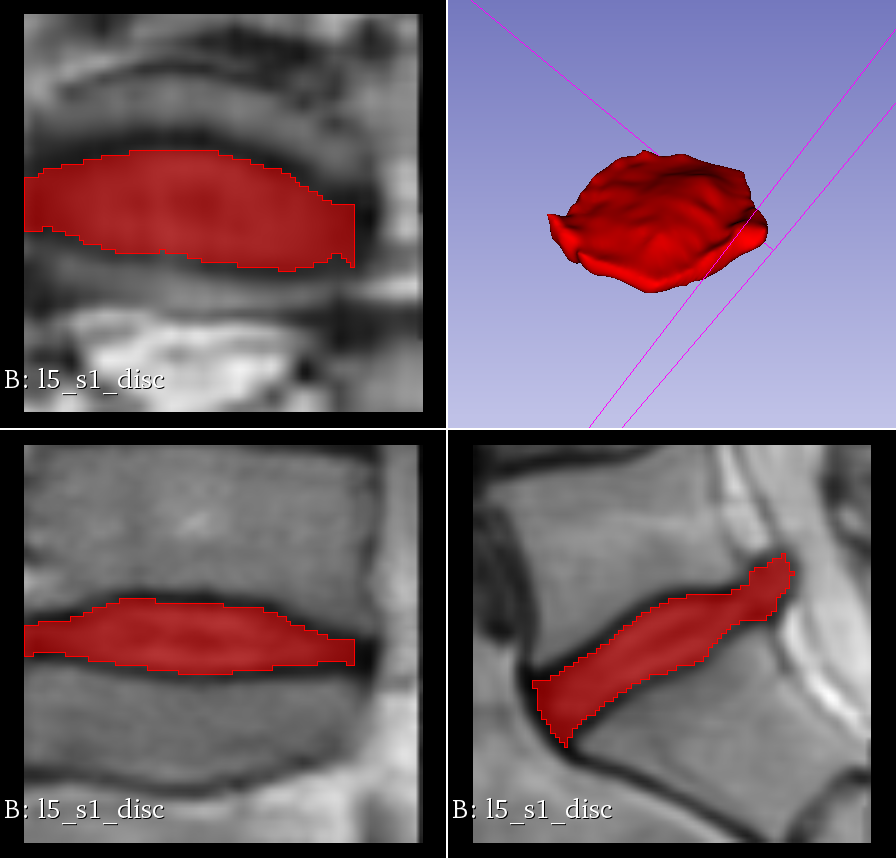

In [21]:
slicernb.ViewDisplay('FourUp', False)

Smooth the segmentation

In [22]:
segmentEditorWidget.setActiveEffectByName("Smoothing")
effect = segmentEditorWidget.activeEffect()
effect.self().onApply()

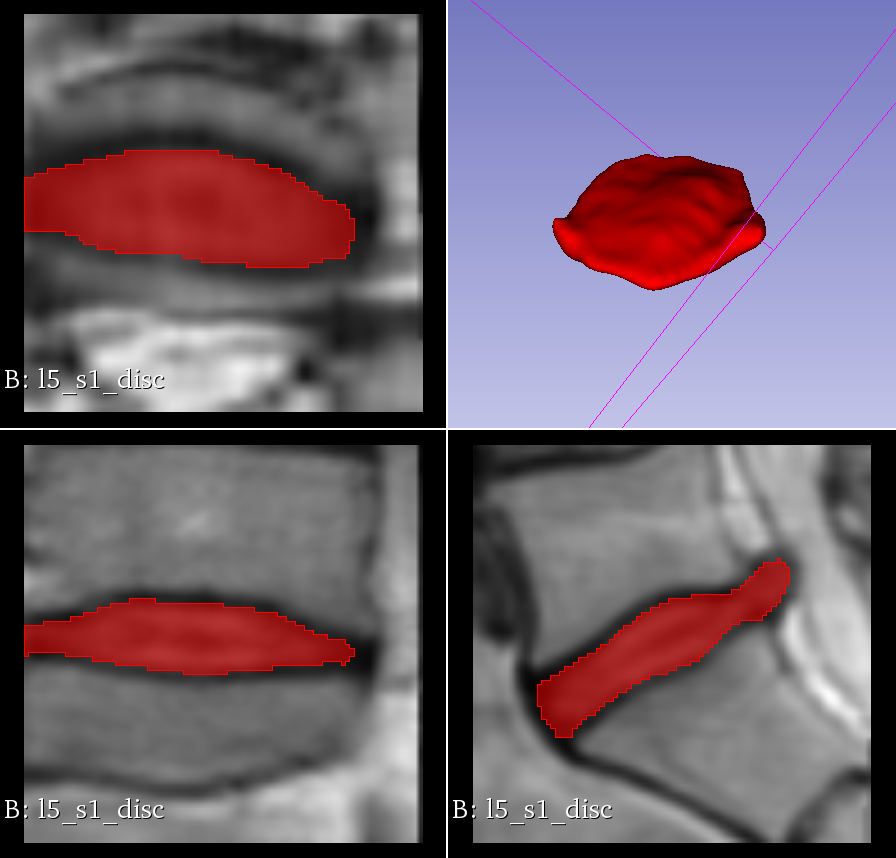

In [23]:
slicernb.ViewDisplay('FourUp', False)

Dilate 1mm

In [24]:
segmentEditorWidget.setActiveEffectByName("Margin")
effect = segmentEditorWidget.activeEffect()
effect.setParameter("MarginSizeMm", "1")
effect.self().onApply()

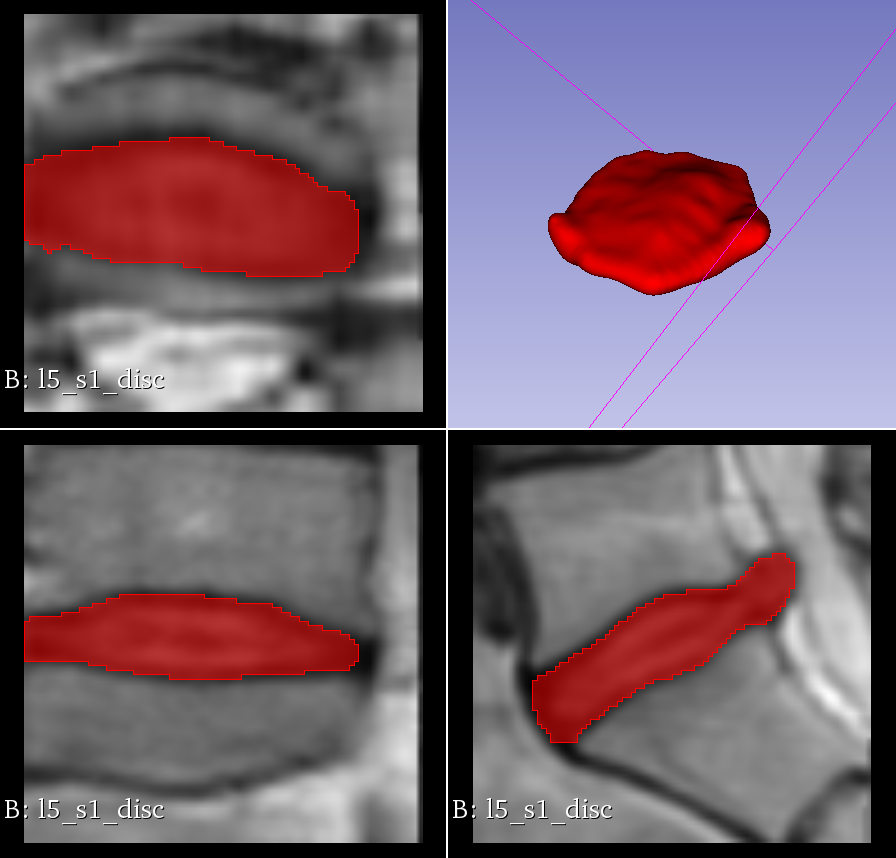

In [25]:
slicernb.ViewDisplay('FourUp', False)

Delete the background segment and save segmentation to disc.

In [26]:
segmentationNode.GetSegmentation().RemoveSegment(backgroundSegment)
slicer.util.saveNode(segmentationNode, os.path.join(os.getcwd(), 'img', 'l5_s1_disc_segmentation.nrrd'))

True